# The Activation Normalization Layer

The activation normalization layer uses a location and a scale parameter to perform an affine transformation of the data. These two parameters are initialized on the first batch that is passed through the layer to create zero mean and unit standard deviation. During calibration, these parameters can change to more optimal values. *Documentation: Search the [modelling page](https://gyoza.readthedocs.io/en/latest/gyoza.modelling.html) for ActivationNormalization.*

In [ ]:
import tensorflow as tf, matplotlib.pyplot as plt, numpy as np, matplotlib as mpl
from gyoza.modelling import flow_layers as mfl, masks as gmm, standard_layers as msl
from gyoza.tutorials import data_iterators as mdis, data_synthesis as gtd, plotting as gtp

from ipywidgets import interact, fixed
tf.keras.backend.set_floatx('float64')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## Data Generation

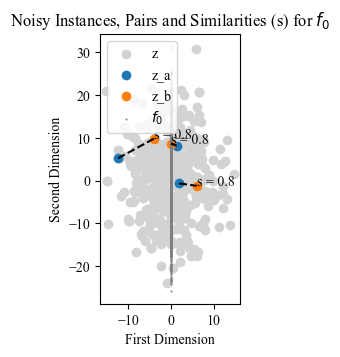

In [ ]:
manifold_name = 'f_0'

# Generate points along a line
M = 2**12; N = 2 # Instance count, dimension count
gtd.reset_random_number_generators(seed=42) # Reproducability
S = np.random.normal(loc=0, scale=1.0, size=[M])

# Set up the raw manifold function
manifold_function = lambda S: (np.zeros(len(S)), S*8) # Move S to second dimension and stretch it

# Generate a dataset
noise_standard_deviation = [5, 0.0]
Z, Y = gtd.create_data_set(S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation) # Z.shape == [M, N], Y.shape = [M, Factor count]
batch_size = 2**8
target_correlations = [0.0, 0.8]
iterator = mdis.factorized_pair_iterator(X=Z, Y=Y, batch_size = batch_size, target_correlations=target_correlations)

# Plot pairs of instances
Z_ab, Y_ab  = next(iterator)
gtp.plot_instance_pairs(S=S, Z_ab=Z_ab, Y_ab=Y_ab, manifold_function=manifold_function, manifold_name=manifold_name)


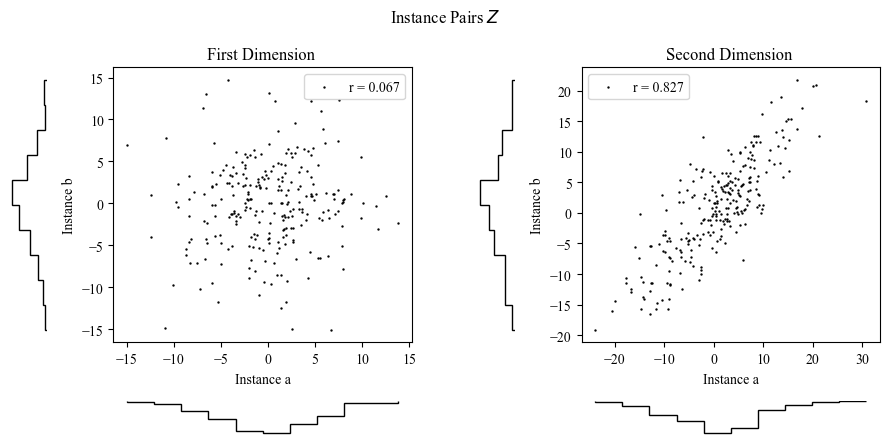

In [3]:
gtp.plot_instance_pairs_2(Z_ab=Z_ab)

## Model Creation

In [10]:
# Create network
def create_network():
    network = mfl.SupervisedFactorModel(layers=[mfl.ActivationNormalization(axes=[1], shape=[N])], dimensions_per_factor=[1,1], sigma=1.0)
    network.build() # Initialization of some layer parameters
    return network

gtd.reset_random_number_generators(seed=4) # Reproducability
network = create_network()

# Inspect scaling parameter
print("Variable path: ", network.trainable_variables[1].path)
print("Variable value: ", network.trainable_variables[1].value.numpy(), " (default initialization of dimension 0 and 1, respectively)") # It is set to the standard deviation by default which is already optimal

# Pass Z through to trigger data-agnostic initialization
network(Z)
print("Variable value: ", network.trainable_variables[1].value.numpy(), " (initialization after first pass of data, equals standard deviations of dimension 0 and 1, respectively)") # It is set to the standard deviation by default which is already optimal

Variable path:  activation_normalization_1/__scale__
Variable value:  [1. 1.]  (default initialization of dimension 0 and 1, respectively)
Variable value:  [4.92668815 7.97564522]  (initialization after first pass of data, equals standard deviations of dimension 0 and 1, respectively)


In [ ]:

# Plot input and output
gtp.plot_input_output(network, S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation, manifold_name=manifold_name, zoom_output=True)

## Model Training

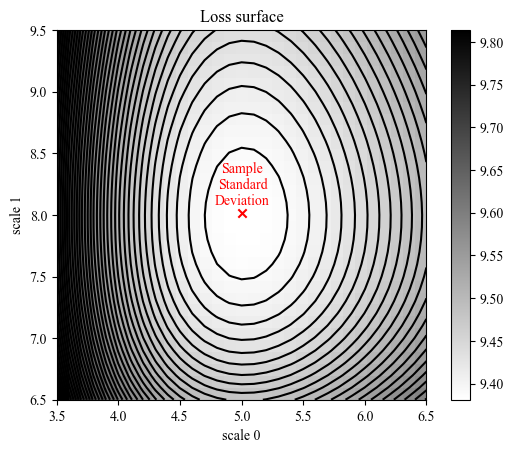

In [6]:
# Compute the loss surface
lb0, ub0, s0 = 3.5, 6.5, 0.1
lb1, ub1, s1 = 6.5, 9.5, 0.1
L = np.zeros([len(np.arange(lb0, ub0+s0 , s0)), len(np.arange(lb1, ub1+s1 , s1))])
std = np.array([0.0, 0.0])

# Repeat a few times to average out noise inherent to the pair sampling procedure
for k in range(5):
    # Iterate the scale for first and second dimension
    (Z_ab, Y_ab) = next(iterator)
    for i, scale_0 in enumerate(np.arange(lb0, ub0+s0 , s0)):
        for j, scale_1 in enumerate(np.arange(lb1, ub1+s1 , s1)):
            network.trainable_variables[1].assign([scale_0, scale_1])    
            loss = network.compute_loss(data=(Z_ab, Y_ab))
            L[i,j] += loss /5
    std += np.std(Z_ab[:,0,:], axis=0) /5

# Plot
L = L.T
plt.figure(); plt.title('Loss surface')
plt.imshow(np.flipud(L), extent=[lb0,ub0,lb1,ub1], colorizer=mpl.colorizer.Colorizer(cmap='binary'))
plt.colorbar()
plt.contour(*np.meshgrid(np.arange(lb0, ub0+s0 , s0),np.arange(lb1, ub1+s1 , s1)),L, 50,colors='k')
plt.scatter(*std, marker='x', c='r'); plt.text(*np.round(std+[0,+0.06],3), s='Sample\nStandard\nDeviation', color='r', ha='center')
plt.gca().set_aspect('equal'); plt.xlabel("scale 0"); plt.ylabel("scale 1")

plt.show()

In [1]:
# Perturb scale parameters to show that they will be optimized by gradient descent later
network.trainable_variables[1].assign([3, 15.0])
print("Variable value: ", network.trainable_variables[1].value.numpy(), " (tweaked scaling parameters of dimension 0 and 1, respectively)")


NameError: name 'network' is not defined

25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 265ms/step - Train Loss: 9.3538


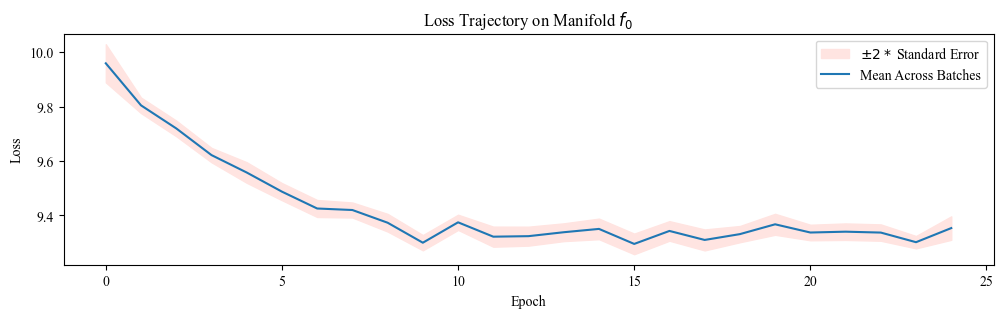

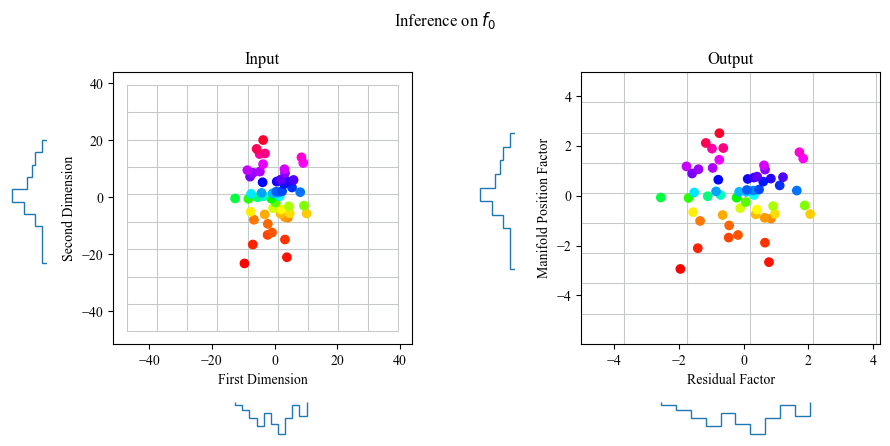

Variable path:  activation_normalization_1/__scale__
Variable value:  [4.9457933  7.95510871]  (optimized scale parameters of dimension 0 and 1, respectively)


In [ ]:
# Ensure scale starts out as suboptimal
network.trainable_variables[1].assign([3, 15.0])

# Calibrate network
learning_rate = 0.5
network.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate))
epoch_count = 25
epoch_loss_means, epoch_loss_standard_deviations = network.fit(iterator=iterator, epoch_count=epoch_count, batch_count=M//batch_size)
gtp.plot_loss_trajectory(epoch_loss_means=epoch_loss_means, epoch_loss_standard_deviations=epoch_loss_standard_deviations, manifold_name=manifold_name)

# Plot input and output
gtp.plot_input_output(network, S=S, manifold_function=manifold_function, noise_standard_deviation=noise_standard_deviation, manifold_name=manifold_name, zoom_output=True)

# Check scaling parameters after optimization
print("Variable path: ", network.trainable_variables[1].path)
print("Variable value: ", network.trainable_variables[1].value.numpy(), " (optimized scale parameters of dimension 0 and 1, respectively)")

## Evaluation

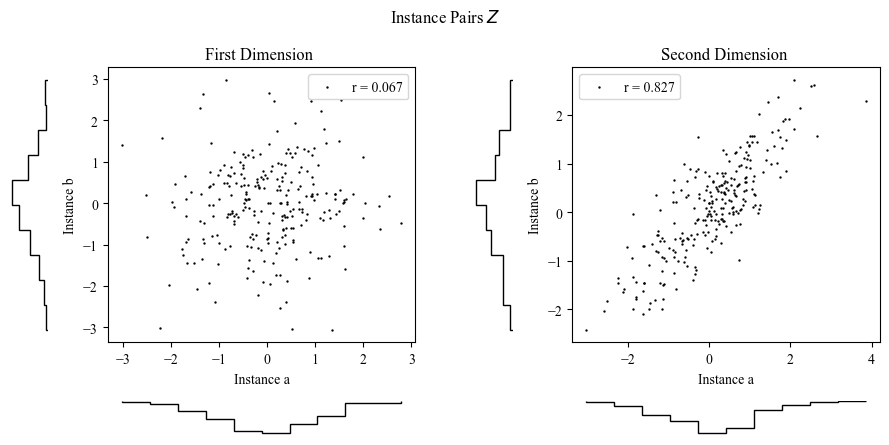

In [ ]:
Z_tilde_a = network(Z_ab[:,0,:])[:,np.newaxis,:] 
Z_tilde_b = network(Z_ab[:,1,:])[:,np.newaxis,:]
Z_tilde_ab = tf.concat([Z_tilde_a, Z_tilde_b], axis=1)
gtp.plot_instance_pairs_2(Z_ab=Z_tilde_ab)